In [ ]:
#Only ever worked okay, but did work

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, metrics, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import classification_report

import os
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
import h5py

In [3]:
hf = h5py.File('simulated-attpc-events.h5', 'r')

In [5]:
hf['features'].dtype

dtype('uint8')

In [6]:
hf['targets'].dtype

dtype('uint8')

In [4]:
list(hf.keys())

['features', 'targets']

In [5]:
# 50,000 128x128 images
hf['features'].shape

(50000, 128, 128)

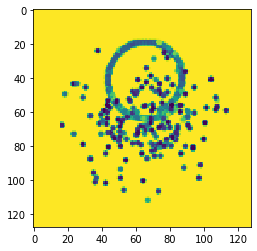

In [6]:
plt.imshow(hf['features'][4])

In [7]:
#0 is proton, 1 is C, 2 is other

print(hf['targets'][3])

1


In [8]:
data = hf['features']
label = hf['targets']

In [9]:
train = data[0:8999]
test = data[9000:11000]
train_label = label[0:8999]
test_label = label[9000:11000]

In [10]:
image_width, image_length = 128, 128
image_shape = (128,128)

#Reshape data (https://www.machinecurve.com/index.php/2020/04/13/how-to-use-h5py-and-keras-to-train-with-data-from-hdf5-files/)

train = train.reshape((len(train), image_width, image_length))
test = test.reshape((len(test), image_width, image_length))

In [11]:
#Looking at data. Works, just takes up space so commented out for later runs

#plt.figure(figsize=(10,10))
#for i in range(36):
#   plt.subplot(6,6,i+1)
#  plt.xticks([])
#   plt.yticks([])
#    plt.grid(False)
#    plt.imshow(train[i], cmap=plt.cm.binary)
#    plt.xlabel(label[i])
#plt.show()

In [12]:
#Normalize datasets
train = 1-(train/255.0)
test = 1-(test/255.0)

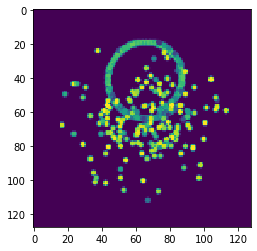

In [13]:
train[4]
plt.imshow(train[4])

In [14]:
# This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [15]:
#Clear previous runs
#!rm -rf ./logs/

In [16]:
#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard


log_dir = "logs/fit/" + "FCNN" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch = 0)

In [17]:
FCNN_model = tf.keras.Sequential()
FCNN_model.add(layers.Flatten(input_shape=(128,128)))
FCNN_model.add(layers.Dense(105, activation='relu'))
FCNN_model.add(layers.Dropout(0.74))
FCNN_model.add(layers.Dense(105, activation='relu'))
FCNN_model.add(layers.Dropout(0.74))
FCNN_model.add(layers.Dense(3, activation = 'softmax'))

In [18]:
#https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

#algorithms or methods used to change the attributes of your neural network such as weights 
#and learning rate in order to reduce the losses

FCNN_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

In [19]:
FCNN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 105)               1720425   
_________________________________________________________________
dropout (Dropout)            (None, 105)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 105)               11130     
_________________________________________________________________
dropout_1 (Dropout)          (None, 105)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 318       
Total params: 1,731,873
Trainable params: 1,731,873
Non-trainable params: 0
______________________________________________

In [20]:
FCNN_history = FCNN_model.fit(train, train_label,
                             epochs=45,
                             batch_size = 32,
                             shuffle = True,
                             callbacks = [tensorboard_callback, callback],
                             validation_split = 0.3
                             )

Epoch 1/45
197/197 [==============================] - 4s 18ms/step - loss: 1.1229 - accuracy: 0.3310 - val_loss: 1.0932 - val_accuracy: 0.3978
Epoch 2/45
197/197 [==============================] - 3s 17ms/step - loss: 1.0954 - accuracy: 0.3613 - val_loss: 1.0811 - val_accuracy: 0.4037
Epoch 3/45
197/197 [==============================] - 3s 18ms/step - loss: 1.0933 - accuracy: 0.3670 - val_loss: 1.0682 - val_accuracy: 0.4448
Epoch 4/45
197/197 [==============================] - 3s 17ms/step - loss: 1.0747 - accuracy: 0.3910 - val_loss: 1.0392 - val_accuracy: 0.5519
Epoch 5/45
197/197 [==============================] - 3s 18ms/step - loss: 1.0593 - accuracy: 0.4126 - val_loss: 1.0072 - val_accuracy: 0.6074
Epoch 6/45
197/197 [==============================] - 3s 18ms/step - loss: 1.0250 - accuracy: 0.4493 - val_loss: 0.9706 - val_accuracy: 0.6344
Epoch 7/45
197/197 [==============================] - 3s 17ms/step - loss: 0.9884 - accuracy: 0.4786 - val_loss: 0.9522 - val_accuracy: 0.6304

In [21]:
#%tensorboard --logdir logs/fit

In [22]:
result = FCNN_model.evaluate(test, test_label, verbose=2)

63/63 - 0s - loss: 0.6924 - accuracy: 0.7105


In [23]:
predictions = np.argmax(FCNN_model.predict(test[:]),axis=1)

In [24]:
predictions.shape

(2000,)

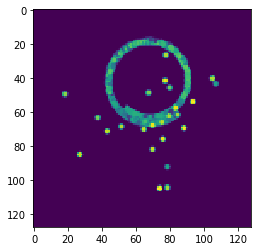

In [25]:
test[3]
plt.imshow(test[3])

In [26]:
predictions[3]

0

In [27]:
print(classification_report(test_label, predictions))

              precision    recall  f1-score   support

           0       0.67      0.66      0.66       657
           1       0.73      0.82      0.78       660
           2       0.72      0.65      0.69       683

    accuracy                           0.71      2000
   macro avg       0.71      0.71      0.71      2000
weighted avg       0.71      0.71      0.71      2000



In [28]:
print(FCNN_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


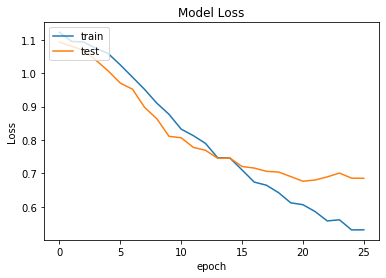

In [29]:
plt.plot(FCNN_history.history['loss'])
plt.plot(FCNN_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import itertools

In [31]:
cm = confusion_matrix(test_label, predictions)

In [32]:
#plot_confusion_matrix(test_label, predictions, normalize='all')
#plt.show()

In [33]:
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         include_values=True,
                         cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

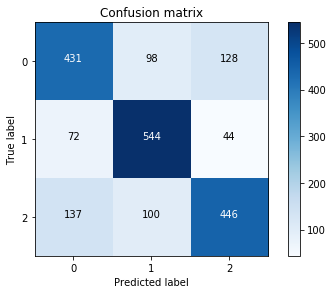

In [34]:
cm_plot_labels = ['0', '1', '2']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion matrix')

In [35]:
#Independently calculating classification report values to see where they come from

#Precision = TP / (TP + FP)
precision_0 = 402 / (402+(73+85))
precision_1 = 481 / (481+(70+48))
precision_2 = 519 / (519+105+217)
print(precision_0)
print(precision_1)
print(precision_2)

0.7178571428571429
0.8030050083472454
0.6171224732461356


In [36]:
#Recall = TP / (TP + FN)
recall_0 = 402 / (402+70+217)
recall_1 = 481 / (481+73+105)
recall_2 = 519 / (519+85+48)
print(recall_0)
print(recall_1)
print(recall_2)

0.5834542815674891
0.7298937784522003
0.7960122699386503


In [37]:
#F1 = 2TP / (2TP + FP + FN)
f1_0 = (2*402) / ((2*402)+73+85+70+217)
f1_1 = (2*481) / ((2*481)+70+48+73+105)
f1_2 = (2*519) / ((2*519)+105+217+85+48)
print(f1_0)
print(f1_1)
print(f1_2)

0.6437149719775821
0.7647058823529411
0.695244474212994
